This is for FEM modelling of Truss element right from scratch.

Lets define coords and modulus of elasticity and area of members.

In [13]:
import numpy as np
import math 
KN=1
mm=1
m=1.0e3*mm
MPa=1
GPa=MPa*1.0e3


node_coords=np.array([[0,0],[800,0],[400,400]])

E=200*GPa

#Area
A1=1500*mm**2
A2=2000*mm**2
A3=2000*mm**2


Let us visualize model.

In [14]:
import matplotlib.pyplot as plt
print(node_coords[:,0])

[  0 800 400]


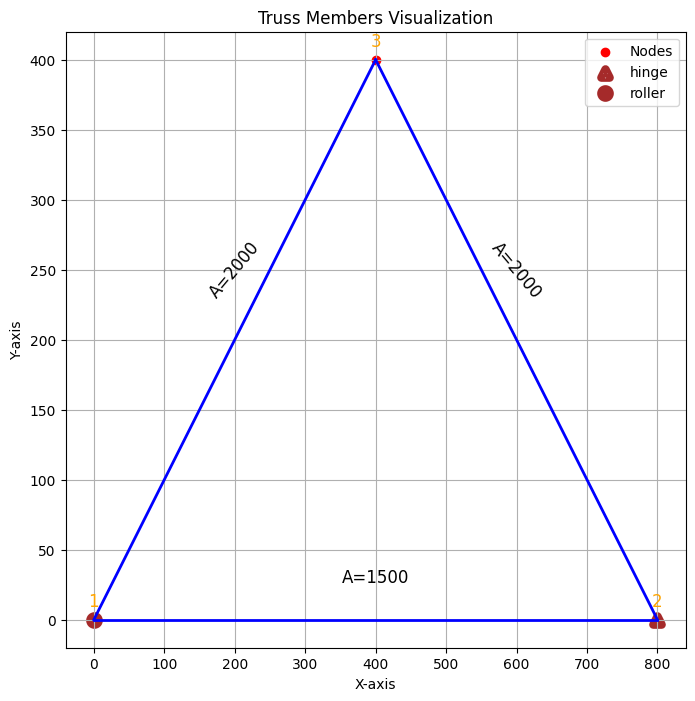

In [15]:

plt.figure(figsize=[8,8])
for i in range(len(node_coords)-1):
    plt.plot([node_coords[i,0],node_coords[i+1,0]],[node_coords[i,1],node_coords[i+1,1]],color='blue', linestyle='-', linewidth=2)
    if i==0:
        plt.plot([node_coords[i,0],node_coords[len(node_coords)-1,0]],[node_coords[i,1],node_coords[len(node_coords)-1,1]],color='blue', linestyle='-', linewidth=2)
plt.scatter(node_coords[:,0], node_coords[:,1], color='red', marker='o', label='Nodes')
plt.scatter(node_coords[1,0],node_coords[1,1],color='brown',marker='^',linewidths=6,label='hinge')
plt.scatter(node_coords[0,0],node_coords[0,1],color='brown',marker='o',linewidths=6,label='roller')
plt.text(node_coords[0,0]+200, node_coords[0,1]+250, 'A=2000', fontsize=12, ha='center', va='center',rotation=50)
plt.text(node_coords[1,0]-200, node_coords[0,1]+250, 'A=2000', fontsize=12, ha='center', va='center',rotation=310)
plt.text(node_coords[1,0]-400, node_coords[0,1]+30, 'A=1500',fontsize=12, ha='center', va='center')
for i in range(len(node_coords)):
    plt.text(node_coords[i,0],node_coords[i,1]+13,i+1,color='orange',fontsize=12,ha='center', va='center')

plt.title('Truss Members Visualization')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()

After plotting let us start analysing.

In [16]:
def Kstiff (n1, n2,Area,Elas,dof):
    slope= (n2[1]-n1[1])/(n2[0]-n1[0])
    theta=abs(math.degrees(math.atan(slope)))
    if((n2[1]-n1[1] >= 0 and n2[0]-n1[0] >=0)):
        theta= theta
    elif((n2[1]-n1[1] <= 0 and n2[0]-n1[0] >=0)):
        theta= 360-theta
    elif((n2[1]-n1[1] <= 0 and n2[0]-n1[0] <=0)):
        theta= 180+theta
    else:
        theta= 180-theta
    K=np.zeros((6,6))
    length= np.sqrt(np.square(n2[1]-n1[1])+np.square(n2[0]-n1[0]))
    l= math.cos(math.radians((theta)))
    m=math.sin(math.radians((theta)))
    K[dof[0],dof[0]]=l**2
    K[dof[0],dof[1]]=l*m
    K[dof[0],dof[2]]=-l**2
    K[dof[0],dof[3]]=-l*m
    K[dof[1],dof[0]]=l*m
    K[dof[1],dof[1]]=m**2
    K[dof[1],dof[2]]=-l*m
    K[dof[1],dof[3]]=-m**2
    K[dof[2],dof[0]]=-l**2
    K[dof[2],dof[1]]=-l*m
    K[dof[2],dof[2]]=l**2
    K[dof[2],dof[3]]=l*m
    K[dof[3],dof[0]]=-l*m
    K[dof[3],dof[1]]=-m**2
    K[dof[3],dof[2]]=l*m
    K[dof[3],dof[3]]=m**2
    K=(Area*Elas/length)*K
    return K 


In [17]:
dofele1=np.array([0,1,2,3])
dofele2=np.array([2,3,4,5])
dofele3=np.array([4,5,0,1])
K12=Kstiff(node_coords[0],node_coords[1],A1,E,dofele1)
K23=Kstiff(node_coords[1],node_coords[2],A2,E,dofele2)
K31=Kstiff(node_coords[2],node_coords[0],A3,E,dofele3)
K=K12+K23+K31
print(K[0])

[ 728553.39059327  353553.39059327 -375000.               0.
 -353553.39059327 -353553.39059327]


In [18]:
import sympy as sym
K_sym = sym.Matrix(K.tolist())
F1,F2,F4,u3,u5,u6=sym.symbols('F1 F2 F4 u3 u5 u6')
F=sym.Matrix([F1,F2,0,F4,0,-150])
u=sym.Matrix([0,0,u3,0,u5,u6])
X=K_sym*u
eq=[sym.Eq(X[i], F[i]) for i in range(6)]
sol = sym.solve(eq, (F1,F2,F4,u3,u5,u6))
print(sol)



{F1: -1.81684756160228e-14, F2: 75.0000000000002, F4: 75.0000000000002, u3: 0.000200000000000000, u5: 0.000100000000000000, u6: -0.000312132034355965}


Let's verify using Openseespy.

In [111]:
import openseespy.opensees as op
import opsvis as ops
import pandas as pd

In [112]:
op.wipe()
op.model('basic','-ndm',2,'-ndf',2)


In [113]:
#Nodes

op.node(1,0,0)
op.node(2,800,0)
op.node(3,400,400)

#uniaxialMaterial('Elastic', matTag, E, eta=0.0, Eneg=E)
op.uniaxialMaterial('Elastic',1,200*GPa)

#element('Truss', eleTag, *eleNodes, A, matTag)
op.element('Truss',1,1,2,1500,1)
op.element('Truss',2,2,3,2000,1)
op.element('Truss',3,1,3,2000,1)

In [114]:
#fix
op.fix(1,0,1,0)
op.fix(2,1,1,0)

In [115]:
#timeSeries('Constant', tag, '-factor', factor=1.0)
op.timeSeries('Constant',1)
#pattern('Plain', patternTag, tsTag, '-fact', fact)
op.pattern('Plain',1,1)
#load(nodeTag, *loadValues)
op.load(3,0,-150*KN)

In [116]:
#Analysis

op.constraints('Plain')
op.numberer('RCM')
op.system('FullGeneral')
#test('NormUnbalance', tol, iter)
op.test('NormUnbalance',1e-10,100)
op.algorithm('Newton')
op.integrator('LoadControl', 1.0)
op.analysis('Static')

op.analyze(1)

0

In [117]:
u6=op.nodeDisp(3,2)
op.reactions()
F1=op.nodeResponse(1,2,6)
F2=op.nodeResponse(2, 2, 6)

print(f"Force at node1: {F1} \n Force at node 2: {F2} \n u6: {u6}")

Force at node1: 75.0 
 Force at node 2: 75.0 
 u6: -0.0003121320343559643


This particular code from openseespy verifies my previous code.